## This notebook is used to reproduce some plots in the original CellBox paper

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import ast 
from matplotlib.lines import Line2D

In [3]:
smaller_size = 13
medium_size = 14
bigger_size = 16

plt.rc('font', size=bigger_size)          # controls default text sizes
plt.rc('axes', titlesize=medium_size)     # fontsize of the axes title
plt.rc('axes', labelsize=medium_size)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=smaller_size)    # fontsize of the tick labels
plt.rc('ytick', labelsize=smaller_size)    # fontsize of the tick labels
plt.rc('legend', fontsize=smaller_size)    # legend fontsize
plt.rc('figure', titlesize=bigger_size)  # fontsize of the figure title

### ODE plot for Pytorch, figure 2B of CellBox

In [46]:
index = "052"
root = "/data/weirauchlab/team/ngun7t/cellbox_results/results/Pytorch_RP_fig2_rep_b0bf0e27d3c96f91d2e1c66b15d9b7c0"
#root = "/data/weirauchlab/team/ngun7t/cellbox_results/results/Tensorflow_RP_fig2_rep_3db3abf024fd02760dedd90c6b3cbae9"
loss = pd.read_csv(os.path.join(root, f'seed_{index}/record_eval.csv'), usecols=range(8))
noi_index = np.genfromtxt("/users/ngun7t/Documents/cellbox-jun-6/data/node_Index.csv", 
                          dtype = str)[[2,3,82,31,40,83]]

def _simu(t_mu, W, alpha, eps, x_0 = np.zeros([99]), dT=0.1, n_T=100):
    def _dXdt(x):
        dXdt = eps[:, 0] * np.tanh(np.matmul(W, x) + t_mu) - alpha[:, 0] * x
        return dXdt
    
    x = x_0
    trace = x_0
    for i in range(n_T):
        """ Integrate with Heun's Method """
        dXdt_current = _dXdt(x)
        dXdt_next = _dXdt(x + dT * dXdt_current)
        x = x + dT * 0.5 * (dXdt_current + dXdt_next)
        trace = np.append(trace,x)
    trace = np.reshape(trace, [n_T+1, 99])
    return trace


def b(index = '000', condition = 0, nT = 400):

    #os.chdir(root+'/b11_'+index)
    #os.chdir(root+'/seed_'+index)

#     alpha = pd.read_csv(glob.glob('*%d*json.4*alpha*csv'%nT)[0], index_col = 0).values
#     eps = pd.read_csv(glob.glob('*%d*json.4*eps*csv'%nT)[0], index_col = 0).values
#     w = pd.read_csv(glob.glob('*%d*json.4*W*csv'%nT)[0], index_col = 0).values
    alpha = pd.read_csv(glob.glob(os.path.join(f"{root}/seed_{index}", '6_best.params.alpha*csv'))[0], index_col = 0).values
    eps = pd.read_csv(glob.glob(os.path.join(f"{root}/seed_{index}", '6_best.params.eps*csv'))[0], index_col = 0).values
    w = pd.read_csv(glob.glob(os.path.join(f"{root}/seed_{index}", '6_best.params.W*csv'))[0], index_col = 0).values

    pert = np.genfromtxt('/users/ngun7t/Documents/cellbox-jun-6/data/pert.csv', dtype = np.float32, delimiter = ',')
    expr = np.genfromtxt('/users/ngun7t/Documents/cellbox-jun-6/data/expr.csv', dtype = np.float32, delimiter = ',')
    #pos = np.genfromtxt('random_pos.csv')

    noi = [2,3,31,40,82,83]
    trace = _simu(pert[condition], w, alpha, eps, n_T = int(nT))
    trace_subset = trace[:,noi].transpose()
    xs = np.linspace(0, nT/10, int(nT)+1)
    real = expr[condition, noi]

    for t, trace_i in enumerate(trace_subset):
        plt.axhline(y = real[t], xmax = 0.98, ls="dashed",  alpha = 0.8,
                    color = sns.color_palette("deep")[t])
                    
        plt.plot(xs, trace_i, color = sns.color_palette("deep")[t], 
                 label = noi_index[t], alpha = 0.8)


    #plt.axvline(x = nT/10, color="black", ls="dashed", alpha = 0.8, linewidth=2)
    return trace, real

def moving_average(sequence, n=5) :
    ret = np.cumsum(sequence, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

Text(-0.13, 1.02, 'B')

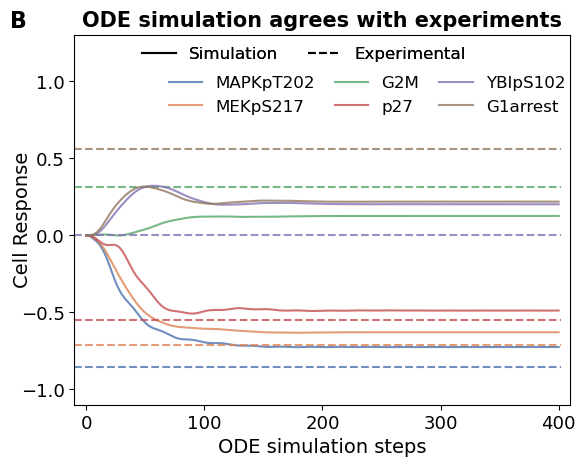

In [47]:
fig, ax = plt.subplots(nrows=1, ncols=1)
trace, real = b(index = index, condition = 0, nT = 400)
#plt.axvline(x = 40, ymin=0.03, ymax=0.73, color="black", ls="dashed", alpha = 0.8, linewidth=2)
plt.xlabel('ODE simulation steps')
plt.ylabel('Cell Response', labelpad=-8)
plt.xlim([-1,41])
plt.ylim([-1.1,1.3])
plt.xticks([0,10,20,30,40],[0,100,200,300,400])
plt.yticks([-1,-0.5,0,0.5,1.0])

custom_lines = [Line2D([0], [0], color='k'), Line2D([0], [0], color='k', ls="dashed")]
legend1 = plt.legend(loc='upper right', bbox_to_anchor=(1.02, 0.93), frameon=False, 
                     ncol=3, prop={'size': 12, "weight": "normal"}, columnspacing=1.2)
legend2 = plt.legend(custom_lines, ['Simulation', 'Experimental'], loc='upper right',
                     ncol=2, bbox_to_anchor=(0.82, 1.01), frameon=False, 
                     prop={'size': 12,'style':'normal','weight':'normal','variant':'normal','stretch':'normal'},
                     columnspacing=1.8)
ax.add_artist(legend1)
ax.add_artist(legend2)
plt.title("ODE simulation agrees with experiments", 
          weight='bold', size=15)
plt.text(-0.13,1.02,'B', weight='bold',transform=ax.transAxes)

### ODE plot for Tensorflow, figure 2B of CellBox

In [52]:
index = "047"
root = "/data/weirauchlab/team/ngun7t/cellbox_results/results/Tensorflow_RP_fig2_rep_3db3abf024fd02760dedd90c6b3cbae9"
loss = pd.read_csv(os.path.join(root, f'seed_{index}/record_eval.csv'), usecols=range(8))
noi_index = np.genfromtxt("/users/ngun7t/Documents/cellbox-jun-6/data/node_Index.csv", 
                          dtype = str)[[2,3,82,31,40,83]]

def _simu(t_mu, W, alpha, eps, x_0 = np.zeros([99]), dT=0.1, n_T=100):
    def _dXdt(x):
        dXdt = eps[:, 0] * np.tanh(np.matmul(W, x) + t_mu) - alpha[:, 0] * x
        return dXdt
    
    x = x_0
    trace = x_0
    for i in range(n_T):
        """ Integrate with Heun's Method """
        dXdt_current = _dXdt(x)
        dXdt_next = _dXdt(x + dT * dXdt_current)
        x = x + dT * 0.5 * (dXdt_current + dXdt_next)
        trace = np.append(trace,x)
    trace = np.reshape(trace, [n_T+1, 99])
    return trace


def b(index = '000', condition = 0, nT = 400):

    #os.chdir(root+'/b11_'+index)
    #os.chdir(root+'/seed_'+index)

#     alpha = pd.read_csv(glob.glob('*%d*json.4*alpha*csv'%nT)[0], index_col = 0).values
#     eps = pd.read_csv(glob.glob('*%d*json.4*eps*csv'%nT)[0], index_col = 0).values
#     w = pd.read_csv(glob.glob('*%d*json.4*W*csv'%nT)[0], index_col = 0).values
    alpha = pd.read_csv(glob.glob(os.path.join(f"{root}/seed_{index}", '6_best.alpha*csv'))[0], index_col = 0).values
    eps = pd.read_csv(glob.glob(os.path.join(f"{root}/seed_{index}", '6_best.eps*csv'))[0], index_col = 0).values
    w = pd.read_csv(glob.glob(os.path.join(f"{root}/seed_{index}", '6_best.W*csv'))[0], index_col = 0).values

    pert = np.genfromtxt('/users/ngun7t/Documents/cellbox-jun-6/data/pert.csv', dtype = np.float32, delimiter = ',')
    expr = np.genfromtxt('/users/ngun7t/Documents/cellbox-jun-6/data/expr.csv', dtype = np.float32, delimiter = ',')
    #pos = np.genfromtxt('random_pos.csv')

    noi = [2,3,31,40,82,83]
    trace = _simu(pert[condition], w, alpha, eps, n_T = int(nT))
    trace_subset = trace[:,noi].transpose()
    xs = np.linspace(0, nT/10, int(nT)+1)
    real = expr[condition, noi]

    for t, trace_i in enumerate(trace_subset):
        plt.axhline(y = real[t], xmax = 0.98, ls="dashed",  alpha = 0.8,
                    color = sns.color_palette("deep")[t])
                    
        plt.plot(xs, trace_i, color = sns.color_palette("deep")[t], 
                 label = noi_index[t], alpha = 0.8)


    #plt.axvline(x = nT/10, color="black", ls="dashed", alpha = 0.8, linewidth=2)
    return trace, real

def moving_average(sequence, n=5) :
    ret = np.cumsum(sequence, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

Text(-0.13, 1.02, 'B')

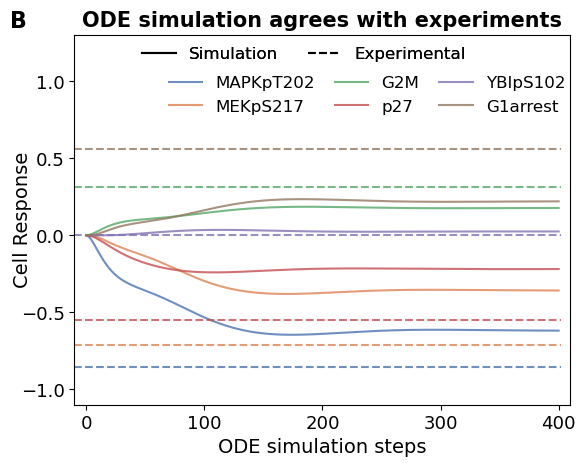

In [53]:
fig, ax = plt.subplots(nrows=1, ncols=1)
trace, real = b(index = index, condition = 0, nT = 400)
#plt.axvline(x = 40, ymin=0.03, ymax=0.73, color="black", ls="dashed", alpha = 0.8, linewidth=2)
plt.xlabel('ODE simulation steps')
plt.ylabel('Cell Response', labelpad=-8)
plt.xlim([-1,41])
plt.ylim([-1.1,1.3])
plt.xticks([0,10,20,30,40],[0,100,200,300,400])
plt.yticks([-1,-0.5,0,0.5,1.0])

custom_lines = [Line2D([0], [0], color='k'), Line2D([0], [0], color='k', ls="dashed")]
legend1 = plt.legend(loc='upper right', bbox_to_anchor=(1.02, 0.93), frameon=False, 
                     ncol=3, prop={'size': 12, "weight": "normal"}, columnspacing=1.2)
legend2 = plt.legend(custom_lines, ['Simulation', 'Experimental'], loc='upper right',
                     ncol=2, bbox_to_anchor=(0.82, 1.01), frameon=False, 
                     prop={'size': 12,'style':'normal','weight':'normal','variant':'normal','stretch':'normal'},
                     columnspacing=1.8)
ax.add_artist(legend1)
ax.add_artist(legend2)
plt.title("ODE simulation agrees with experiments", 
          weight='bold', size=15)
plt.text(-0.13,1.02,'B', weight='bold',transform=ax.transAxes)

### Output of Tensorflow and Pytorch low epoch experiment, using the same weight init for both models

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
torch_arr = pd.read_csv("/data/weirauchlab/team/ngun7t/cellbox_results/results/Pytorch_RP_debug_low-epoch_802f69b16557c900d2a070601051576b/seed_001/1_best.y_hat.loss.141.21248817443848.csv").to_numpy()
tf_arr = pd.read_csv("/data/weirauchlab/team/ngun7t/cellbox_results/results/Tensorflow_RP_debug_low-epoch_98b00bf27d5236a38c1921e5d2877245/seed_001/1_best.y_hat.loss.142.84112803141275.csv").to_numpy()

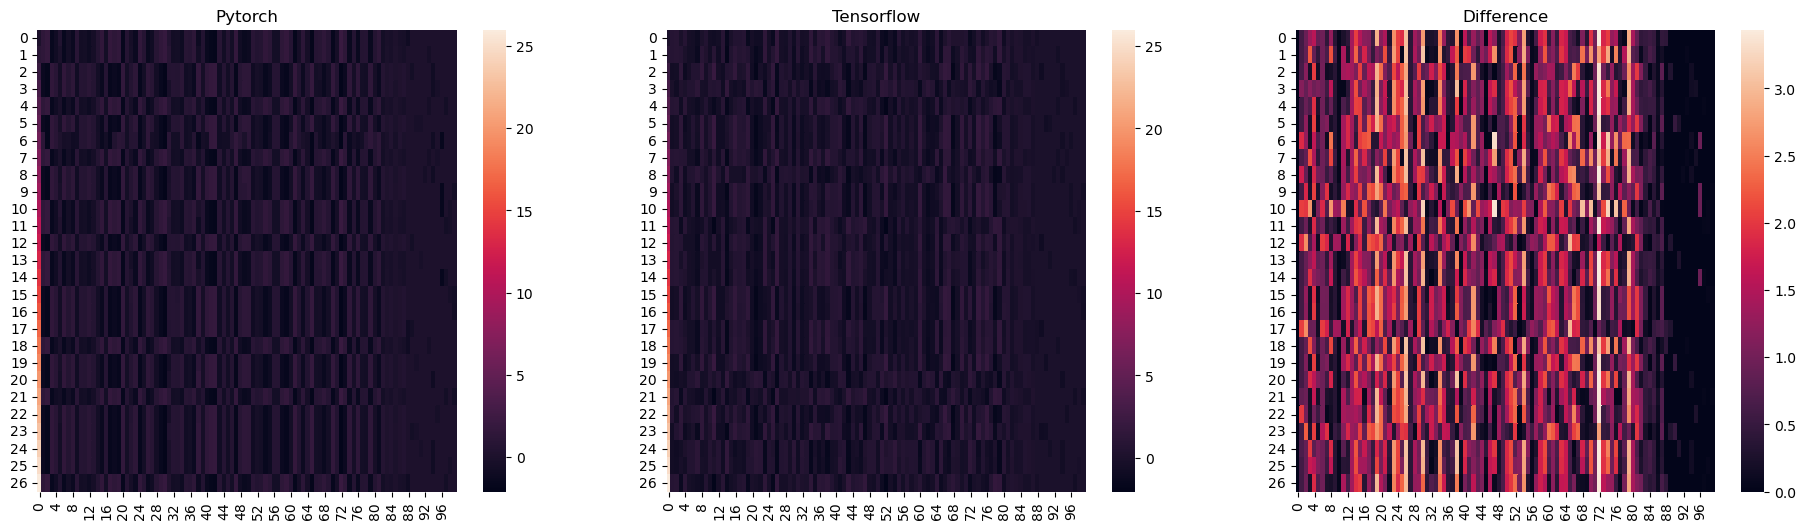

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(23, 6))
sns.heatmap(torch_arr, ax=axes[0])
sns.heatmap(tf_arr, ax=axes[1])
sns.heatmap(np.abs(torch_arr - tf_arr), ax=axes[2])
axes[0].set_title("Pytorch")
axes[1].set_title("Tensorflow")
axes[2].set_title("Difference")
plt.show()